多层全连接的神经网络或者卷积神经网络都只能根据当前的状态进行处理，不能很好的处理时序问题

RNN循环神经网络
梯度爆炸可以靠裁剪后的优化算法即可解决，比如gradient clipping（如果梯度的范数大于某个给定值，将梯度同比收缩）
通过LSTM（长短时记忆网络）改进RNN结构可以消除梯度消失

- 普通的RNN基本结构
- 传统RNN每一步的隐藏单元只是执行一个简单的tanh或ReLU操作

- LSTM主要对隐含层进行了改进
- 在LSMT中，每个神经元相当于一个记忆细胞
- LSMT的关键是细胞的状态，细胞的状态类似于传送带，直接在整个链路上运行，只有一些少量的线性交互

- 门
- LSTM有通过精心设计的称作“门”的结构来去除或者增加信息到细胞状态的能力门是一种让信息选择式通过的方法。包含一个Sigmoid神经网络层和一个点乘操作。
- Sigmoid层输出0到1之间的数值，描述每个部分有多少量可以通过。
- 0代表“不许任何量通过”
- 1代表“允许任何量通过”
- LSTM拥有三个门，来保护和控制细胞状态
- 遗忘门：决定丢弃上一步的哪些信息
- 输入门：决定加入哪些新的信息
- 形成新的细胞状态
- 1. 旧的细胞状态Ct-1与ft相乘丢弃一部分信息
  2. 再加上it*Ct~(i是input输入门)，生成新的细胞状态Ct
- 输出门：决定输出哪些信息
- 把Ct输给tanh函数，得到一个候选的输出值
- 运行一个sigmoid层来确定细胞状态的哪个部分将输出出去

# 下载数据集

In [12]:
# 导入需要用到的库
import os
from tensorflow import keras
import tarfile
import urllib.request
import tensorflow as tf
import numpy as np
import re
import string
from random import randint

In [4]:
# 将文本中不需要的字符清除，如html标签<br/>
def remove_tags(text):
    re_tag = re.compile(r"<[^>]+>")
    return re_tag.sub("",text)

In [5]:
# 读取文件,参数filetype取值为train或者test
def read_files(filetype):
    path = "data/aclImdb/"
    file_list = []
    
    # 读取正面评价的文件的路径，存到file_list列表例
    positive_path = path + filetype+"/pos/"
    for f in os.listdir(positive_path):
        file_list+=[positive_path+f]
    pos_files_num = len(file_list)
    
    # 读取负面评价的文件的路径，存到file_list列表例
    negative_path = path + filetype+"/neg/"
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
    neg_files_num = len(file_list) - pos_files_num
    
    print('read',filetype,"files:",len(file_list))
    print(pos_files_num,"pos files in",filetype,"files")
    print(neg_files_num,"neg files in",filetype,'files')
    # 得到所有的标签。标签用one-hot编码表示，正面评价标签为[1,0],负面评价标签为[0,1]
    all_labels = ([[1,0]] * pos_files_num + [[0,1]] * neg_files_num)
    
    # 得到所有文本
    all_texts = []
    for fi in file_list:
        with open(fi,encoding='utf8') as file_input:
            # 文本中有<br/>这类html标签，将文本传入remove_tags函数
            # 函数里使用正则表达式可以将这样的标签清除掉
            all_texts += [remove_tags(" ".join(file_input.readlines()))]
        
    return all_labels,all_texts

In [6]:
# 得到训练与测试用的标签与文本
train_labels,train_texts = read_files("train")
test_labels,test_texts = read_files("test")

read train files: 25000
12500 pos files in train files
12500 neg files in train files
read test files: 25000
12500 pos files in test files
12500 neg files in test files


In [7]:
#建立Token
token = tf.keras.preprocessing.text.Tokenizer(num_words=4000)
token.fit_on_texts(train_texts)   # 提取最常用的词

In [8]:
train_sequences = token.texts_to_sequences(train_texts)
test_sequences = token.texts_to_sequences(test_texts)

In [9]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences,
                                          padding='post',
                                         truncating='post',
                                          maxlen=400)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,
                                         padding='post',
                                         truncating='post',
                                         maxlen=400)

In [10]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [21]:
model = keras.models.Sequential() #建立序列化的模型
model.add(keras.layers.Embedding(output_dim=32,
                                input_dim=4000,
                                input_length=400))
# 将列表转换为矩阵

In [22]:
# 用RNN，不用把词嵌入层平坦化
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=8)))

In [23]:
model.add(keras.layers.Dense(units=32,activation='relu'))

In [24]:
model.add(keras.layers.Dropout(0.3))

In [25]:
model.add(keras.layers.Dense(units=2,activation='softmax'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 32)           128000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                2624      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 131,234
Trainable params: 131,234
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='adam',    #优化器
             loss = 'categorical_crossentropy',# 交叉熵
             metrics=['accuracy'])# 查看的度量，准确率

In [28]:
history = model.fit(x_train,y_train,
                   validation_split = 0.2,
                   epochs=10,
                   batch_size=128,
                   verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 28s 1ms/sample - loss: 0.6111 - accuracy: 0.6636 - val_loss: 0.8057 - val_accuracy: 0.6364
Epoch 2/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.4017 - accuracy: 0.8352 - val_loss: 0.5030 - val_accuracy: 0.8252
Epoch 3/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.3212 - accuracy: 0.8781 - val_loss: 0.5374 - val_accuracy: 0.7952
Epoch 4/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.2689 - accuracy: 0.9032 - val_loss: 0.4646 - val_accuracy: 0.8252
Epoch 5/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.2235 - accuracy: 0.9240 - val_loss: 0.3951 - val_accuracy: 0.8530
Epoch 6/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 0.2002 - accuracy: 0.9335 - val_loss: 0.5155 - val_accuracy: 0.8410
Epoch 7/10
20000/20000 [==============================] -

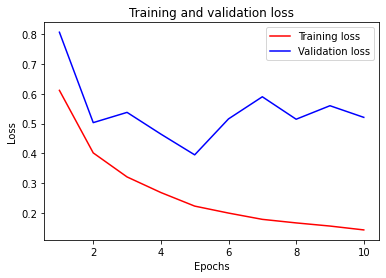

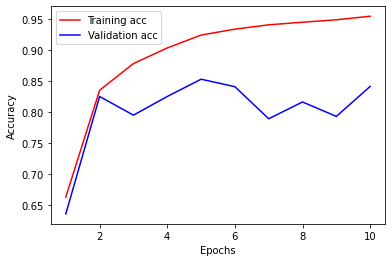

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()     # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history["val_accuracy"]

plt.plot(epochs,acc,'r',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label="Validation acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [30]:
test_loss,test_acc = model.evaluate(x_test,y_test,verbose=1)

print("Test accuracy:",test_acc)

25000/25000 [==============================] - 15s 584us/sample - loss: 0.4639 - accuracy: 0.8514
Test accuracy: 0.8514
